In [1]:
# Read data
import pandas as pd
import numpy as np

crime_data = pd.read_csv('../data/2021.csv')

In [2]:
# Pre-processing and format conversion
crime_data['Month'] = pd.to_datetime(crime_data['Date']).dt.month

print(crime_data['Date'].max())

crime_data.drop('ID', axis=1, inplace=True)
crime_data.drop('Case Number', axis=1, inplace=True)
crime_data.drop('IUCR', axis=1, inplace=True)
crime_data.drop('Beat', axis=1, inplace=True)
crime_data.drop('Updated On', axis=1, inplace=True)
crime_data.drop('Latitude', axis=1, inplace=True)
crime_data.drop('Longitude', axis=1, inplace=True)
crime_data.drop('Location', axis=1, inplace=True)
crime_data.drop('FBI Code', axis=1, inplace=True)
crime_data.drop('Block', axis=1, inplace=True)
crime_data.drop('X Coordinate', axis=1, inplace=True)
crime_data.drop('Y Coordinate', axis=1, inplace=True)
crime_data.drop('Date', axis=1, inplace=True)
crime_data.drop('Year', axis=1, inplace=True)


display(crime_data.head())

for col in crime_data.columns:
    crime_data[col] = col + '-' + crime_data[col].astype(str)
    
display(crime_data.head())

2021-10-11


,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Month
0,DECEPTIVE PRACTICE,ILLEGAL USE CASH CARD,ATM (AUTOMATIC TELLER MACHINE),False,False,18,27.0,8.0,1
1,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,11,28.0,26.0,2
2,SEX OFFENSE,NON-CONSENSUAL DISSEMINATION OF PRIVATE SEXUAL...,RESIDENCE,False,True,25,37.0,25.0,2
3,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,25,37.0,25.0,2
4,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,7,17.0,67.0,2


,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Month
0,Primary Type-DECEPTIVE PRACTICE,Description-ILLEGAL USE CASH CARD,Location Description-ATM (AUTOMATIC TELLER MAC...,Arrest-False,Domestic-False,District-18,Ward-27.0,Community Area-8.0,Month-1
1,Primary Type-BATTERY,Description-DOMESTIC BATTERY SIMPLE,Location Description-APARTMENT,Arrest-False,Domestic-True,District-11,Ward-28.0,Community Area-26.0,Month-2
2,Primary Type-SEX OFFENSE,Description-NON-CONSENSUAL DISSEMINATION OF PR...,Location Description-RESIDENCE,Arrest-False,Domestic-True,District-25,Ward-37.0,Community Area-25.0,Month-2
3,Primary Type-CRIMINAL DAMAGE,Description-TO VEHICLE,Location Description-STREET,Arrest-False,Domestic-False,District-25,Ward-37.0,Community Area-25.0,Month-2
4,Primary Type-ASSAULT,Description-SIMPLE,Location Description-COMMERCIAL / BUSINESS OFFICE,Arrest-False,Domestic-False,District-7,Ward-17.0,Community Area-67.0,Month-2


In [3]:
# Converting to tuples as Apriori takes transaction data as input (list of lists)

crime_data_tuples = [tuple(row) for row in crime_data.values.tolist()]
print("Total number of records =", len(crime_data_tuples))

Total number of records = 158084


In [4]:
min_support = 0.05
min_confidence = 0.9
min_lift = 1

In [5]:
# Running Apriori

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from datetime import datetime


te = TransactionEncoder()
te_ary = te.fit(crime_data_tuples).transform(crime_data_tuples)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

start=datetime.now()
frq_items = apriori(df, min_support = min_support, use_colnames = True)
print("Time taken to run Apriori:", datetime.now() - start)

Time taken to run Apriori: 0:00:14.385911


In [6]:
# Formatting, formatting and writing the frequent itemset to csv

rules = association_rules(frq_items, metric ="lift", min_threshold = min_lift)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules['antecedents_length'] = rules['antecedents'].apply(lambda x: len(x))

rules['consequent support'] = rules['consequent support'].round(decimals = 2)
rules['antecedent support'] = rules['antecedent support'].round(decimals = 2)
rules['support'] = rules['support'].round(decimals = 2)
rules['confidence'] = rules['confidence'].round(decimals = 2)
rules['lift'] = rules['lift'].round(decimals = 2)

filtered_rules = rules[(rules['confidence']  >= min_confidence) ]

print("Number of rules generated:", len(filtered_rules))  

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(filtered_rules.head())
    
filtered_rules.to_csv('output_analysis/2021-Apriori.csv', columns = ['antecedents','consequents','support','confidence','lift'], sep=',', encoding='utf-8', index=False)

Number of rules generated: 85


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length
58,(Description-TO PROPERTY),(Primary Type-CRIMINAL DAMAGE),0.06,0.12,0.06,1.0,8.10,0.053282,inf,1
136,"(Arrest-False, Description-TO PROPERTY)",(Primary Type-CRIMINAL DAMAGE),0.06,0.12,0.06,1.0,8.10,0.050870,inf,2
43,(Description-$500 AND UNDER),(Primary Type-THEFT),0.08,0.19,0.08,1.0,5.28,0.061554,inf,1
51,(Description-OVER $500),(Primary Type-THEFT),0.06,0.19,0.06,1.0,5.28,0.047954,inf,1
98,"(Description-$500 AND UNDER, Arrest-False)",(Primary Type-THEFT),0.07,0.19,0.07,1.0,5.28,0.060764,inf,2


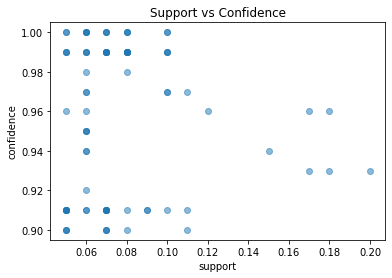

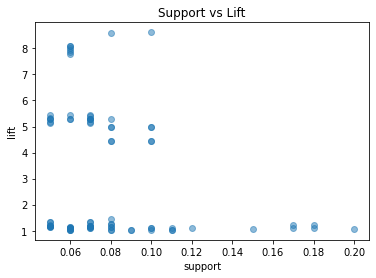

In [7]:
import matplotlib.pyplot as plt
plt.scatter(filtered_rules['support'], filtered_rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

plt.scatter(filtered_rules['support'], filtered_rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

In [8]:
# Efficient apriori

from efficient_apriori import apriori

start=datetime.now()
itemsets, rules = apriori(crime_data_tuples, min_support=min_support, min_confidence=min_confidence)
print("Time taken to run Efficient Apriori:", datetime.now() - start)
print("Number of rules generated:", len(rules))  
display(rules)  

Time taken to run Efficient Apriori: 0:00:00.810036
Number of rules generated: 79


[{Description-$500 AND UNDER} -> {Arrest-False},
 {Description-OVER $500} -> {Arrest-False},
 {Description-SIMPLE} -> {Arrest-False},
 {Description-TO PROPERTY} -> {Arrest-False},
 {Description-TO VEHICLE} -> {Arrest-False},
 {District-4} -> {Arrest-False},
 {District-8} -> {Arrest-False},
 {Location Description-APARTMENT} -> {Arrest-False},
 {Location Description-RESIDENCE} -> {Arrest-False},
 {Month-8} -> {Arrest-False},
 {Month-9} -> {Arrest-False},
 {Primary Type-ASSAULT} -> {Arrest-False},
 {Primary Type-CRIMINAL DAMAGE} -> {Arrest-False},
 {Primary Type-DECEPTIVE PRACTICE} -> {Arrest-False},
 {Primary Type-THEFT} -> {Arrest-False},
 {Description-$500 AND UNDER} -> {Domestic-False},
 {Description-$500 AND UNDER} -> {Primary Type-THEFT},
 {Description-DOMESTIC BATTERY SIMPLE} -> {Domestic-True},
 {Description-DOMESTIC BATTERY SIMPLE} -> {Primary Type-BATTERY},
 {Description-OVER $500} -> {Domestic-False},
 {Description-OVER $500} -> {Primary Type-THEFT},
 {Description-TO PROPERTY} 

In [9]:
#References
# https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data
# Efficient apriori - https://pypi.org/project/efficient-apriori/
# https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/
# http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/